# Information encoding
## Basis encoding : 
Hence $x^m \in \mathcal{D}$, $\mathcal{D}$ the dataset, with $x^m = (b^m_1, ..., b^m_N)$, $b^m_i \in \{0,1\}$, $i \in 1,...,N$, a feature vector.

The state to be prepared is :
$$|\mathcal{D}\rangle = \frac{1}{\sqrt{M}}\sum^M_{m = 1}|x^m\rangle$$

For example, if $x^1 = (01, 01)^T$, $x^2 = (11,10)^T$, we must encode $x^1 = (0101)$ and $x^2 = (1110)$. We can observe the impact of binary precision on the amount of qubits used. Then the superposition to be created is : 
$$|\mathcal{D}\rangle = \frac{1}{\sqrt{2}}|0101\rangle + \frac{1}{\sqrt{2}}|1110\rangle$$
The accepted feature vector should only have binary values to be able to use basis encoding.

Once the model circuit is applied to the encoded features, one can measure it and interpret the state of the result. For example, if we measured the state $|0\rangle$ after the model circuit, it means that the result of the prediction is 0.
If measuring multiple times brings a superposition of results, it means that the result of the model with the given feature vector is uncertain.

## Qubit sampling
Hence we measure the output of our model to be 1 with probability $p$ ($f(x) = 1$ with probability $p$).
We want to estimate the error of measurement given the sample size for our dataset.
First we define the 'frequentist estimator' which all in all can be interpreted as the average of all the output of the circuit for a given sample size $S$ : 
$$\hat{p} = \bar{p} = \frac{1}{S}\sum_{i = 1}^{S}y_i$$
with $y_i$ the output of the circuit.
We want to estimate the confidence interval  $[\hat{p}-\epsilon, \hat{p} + \epsilon]$.
The error $\epsilon$ can be computed as : 
$$\epsilon = z\sqrt{\frac{\hat{p}(1-\hat{p})}{S}}$$
with z the z-value.
One can deduce that the error is majorized by :
$$\epsilon \leq \frac{z}{2\sqrt{S}}$$
Thus the we can deduce that to have an error $\epsilon$, the sample size should be in $\mathcal{O}(\epsilon^{-2})$.
It must be understood that this maximum is reached when $\hat{p} = 0.5$, which is a case of non decision.The following table estimate the sample size depending on the error we want and the probability $p$: 

<img src='error sample.png'>
The results above are true only for the basis encoding.

## Amplitude enconding
The goal of this method is that instead of encoding the information on the state of the qubit, the information is encoded on the amplitude of the qubit. It allows (with the assumption that the backend running the job is noiseless) to encode floating point values way easly compared to basis encoding, where one faces the same challenges as on classical computers.

To encode a dataset with amplitude encoding, one must beforehand check that for the vector $\alpha = (x^1_1, ..., x^1_N, ..., x^M_1, ..., x^M_N)^T$, $|\alpha|^2 = 1$, as the physical construction of a qubit requires that the sum of the amplitude of a superposition of qubits must be equal to 1.

Once this condition is checked, the encoding of the dataset is the following : 
$$|\psi_{\mathcal{D}}\rangle = \sum^{M-1}_{m = 0}\sum^{N-1}_{i = 0} x^m_i|i\rangle|m\rangle$$
The output can be entangled with the latter superposition, or have its own register : 
$$|\psi\rangle = \sum^M_{m = 1}y^m|m\rangle$$
Encoding our state with the phase encoding allows us to reduce the need of qubit to only $log(NM)$, compared to basis encoding that needed $NM$ qubits, with $M$ the number of entries in our dataset and $N$ the amount of features an entry has. This change in the amount of qubit is crucial as quantum machine learning algorithms are scaled polynomially considering the size of the dataset. 

In [2]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_state_qsphere
%matplotlib inline
import math


## The swap test
In quantum machine learning, when using amplitude encoding, we are interested in measuring the inner product of two states. Indeed, if we call $f$ the decision function, we have the relation : 
$$\langle\psi_w|\psi_x\rangle = f(x;w)$$
With w the weight vector and x the feature vector, such that $f(w;x) = w^Tx$
Measuring the inner product of two states is a hard task in quantum computing, but there exists a circuit that help with this kind of measurement, called the swap test.

First, we need to encode our two states $|\psi_w\rangle$ and $|\psi_x\rangle$ into two qubits, and we need an ancilla qubits, initialized at $|0\rangle$

Our system is in state
$$|0\psi_w\psi_x\rangle$$
We then apply an Hadamard gate on the ancilla : 
$$\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)|\psi_w\psi_x\rangle$$
We then use a controlled swap gate, with the control qubit being our ancilla : 
$$\frac{1}{\sqrt{2}}(|0\psi_w\psi_x\rangle + |1\psi_x\psi_w\rangle)$$
Then we apply another Hadamard gate on our ancilla qubit : 
$$\frac{1}{2}|0\rangle\otimes(\psi_w\psi_x+\psi_x\psi_w) + \frac{1}{2}|1\rangle\otimes(\psi_w\psi_x-\psi_x\psi_w)$$

When we measure the probability to get the state 0 on the ancilla, we are applying the following formula : 
$$p_0 = |\langle0|\psi\rangle|^2 = \frac{1}{2}-\frac{1}{2}|\langle\psi_w|\psi_x\rangle|^2$$

Thus, by computing $\sqrt{1-2p_0}$, one can deduce the inner product $|\langle\psi_w|\psi_x\rangle|$

A demonstration is available here:

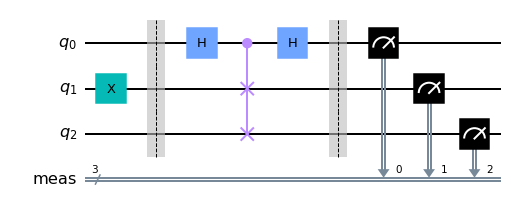

In [9]:
qc = QuantumCircuit(3) #Our ancilla is on the first qubit
qc.x(1) #We initialize one of our psi qubits to |1>
            #we expect to measure |<psi_1|psi_2>| = |<0|1>| ~ 0
qc.barrier()
qc.h(0)
qc.cswap(0,1,2)
qc.h(0)
qc.measure_all()
display(qc.draw(output = 'mpl'))

shots = 8192
backend = Aer.get_backend('qasm_simulator')
job = execute(qc,backend, shots = shots)
result = job.result()


In [11]:
#We then want to extract the counts when then ancilla is in state |0>
res = result.get_counts()
start0 = []
for keys in res.keys():#We extract every result count that begins with a '0' and we add them together
    if(keys[0] == '0'):
        start0.append(res.get(keys))
p0 = sum(start0)/shots#The sum is divided by the number of shot to get the approximate probability to get 0
print("The inner product is : ",math.sqrt(round(1-2*p0)))


The inner product is :  0.0


## Interference circuits
Another way to measure the inner product of two states is to use an interference circuit : 

Starting with an ancilla qubit in state $|0\rangle$, two states $|\psi_a\rangle$ and $|\psi_b\rangle$, one should be able to create the following entanglement :
$$|\psi\rangle = \frac{1}{\sqrt{2}}(|0\psi_a\rangle + |1\psi_b\rangle)$$
Once this state is created, an Hadamard gate can be applied to the ancilla qubit, leading $|\psi\rangle$ to the state : 
$$\frac{1}{2}|0\rangle\otimes(|\psi_a\rangle+|\psi_b\rangle) + \frac{1}{2}|1\rangle\otimes(|\psi_a\rangle-|\psi_b\rangle)$$
Finally, measuring $p(0) = |\langle 0|\psi\rangle|^2$, one can determine the inner product : 
$$p(0) = \frac{1}{4}\langle\psi_{a+b}|\psi_{a+b}\rangle$$
To extract the inner product $\langle\psi_a|\psi_b\rangle$, we must decompose $\langle\psi_{a+b}|\psi_{a+b}\rangle$:
$$(a+b)^T(a+b) = \sum_i(a_i+b_i)^2$$
$$ = \sum_i a_i^2 + \sum_i b_i^2 + 2\sum_ia_ib_i$$
$$ = 2+2a^Tb$$
Thus we have : 
$$p(0) = \frac{1}{4}\langle\psi_{a+b}|\psi_{a+b}\rangle$$
$$=\frac{1}{4}(2+a^Tb)$$
$$=\frac{1}{2}+\frac{1}{2}a^Tb$$